# Premium Optimization

**Objective:** Calculate a dynamic, risk‑based premium for each policy by combining:

1. **Predicted probability of a claim** (`P_claim`)  
2. **Predicted claim severity** (`E_severity`)  
3. **EX_sev_sev_sevpense loading** (fixed administrative fee)  
4. **Profit margin** (percentage of expected loss)

**Formula:**
Optimized Premium = P_claim × E_severity + ExpenseLoading + ProfitMarginRate 
---

**Outline:**
1. Imports & Model Loading  
2. Data Loading & Preprocessing  
3. Generate Predictions  
4. Compute Optimized Premium  
5. Compare to Current Premium  
6. Visualizations  
7. Business Interpretation  
8. Save Results


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os 
import sys
sys.path.append(os.path.abspath('../../src'))
from Data_Processing import load_and_clean_data, encode_categoricals, scale_and_transform

# Load our two models
clf_prob = joblib.load("../../Models/claim_Probability.joblib")
reg_sev  = joblib.load("../../Models/claim_severity_final.joblib")

print("✅ Models loaded:")
print(" - Claim probability model:", type(clf_prob).__name__)
print(" - Claim severity model:", type(reg_sev).__name__)


✅ Models loaded:
 - Claim probability model: LogisticRegression
 - Claim severity model: RandomForestRegressor


In [2]:
df = load_and_clean_data("../../Data/cleaned_data_for_StatisticalAnalysis.csv")
print(f"✅ Raw data: {df.shape[0]} rows, {df.shape[1]} columns")

c:\Users\adoni\Desktop\KAIM COURSE\WEEK-3\InsuranceRiskAnalysisAndPredictiveModeling\src\Data_Processing.py:17: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


✅ Raw data: 618319 rows, 24 columns


In [5]:
# Prepare data for CLAIM PROBABILITY (LogisticRegression)
df_prob = df.drop(columns=["PostalCode", "mmcode"], errors='ignore').copy()
df_prob['TransactionMonth'] = pd.to_datetime(df_prob['TransactionMonth'])
df_prob['Month'] = df_prob['TransactionMonth'].dt.month
df_prob['VehicleAge'] = df_prob['TransactionMonth'].dt.year - df_prob['RegistrationYear']
df_prob = df_prob.drop(columns=['TransactionMonth', 'RegistrationYear'], errors='ignore')

X_prob = df_prob.drop(columns=['HadClaim', 'TotalClaims', 'Margin', 'LossRatio', 'PolicyID', 'UnderwrittenCoverID'], errors='ignore')
X_prob_enc = encode_categoricals(X_prob)
X_prob_final = scale_and_transform(X_prob_enc)

# Prepare data for CLAIM SEVERITY (XGBoost)
df_sev = df[df['HadClaim'] == 1].copy()  # Only rows with actual claims
df_sev['TransactionMonth'] = pd.to_datetime(df_sev['TransactionMonth'])
df_sev['Month'] = df_sev['TransactionMonth'].dt.month
df_sev['VehicleAge'] = df_sev['TransactionMonth'].dt.year - df_sev['RegistrationYear']
df_sev = df_sev.drop(columns=['TransactionMonth', 'RegistrationYear'], errors='ignore')

X_sev = df_sev.drop(columns=['TotalClaims', 'Margin', 'LossRatio', 'HadClaim', 'PolicyID', 'UnderwrittenCoverID'], errors='ignore')
X_sev_enc = encode_categoricals(X_sev)
X_sev_final = scale_and_transform(X_sev_enc)


## Predictions

- **P(Claim)** → Probability of a claim occurring
- **E(Severity)** → Expected total claim cost **if** a claim occurs
- **Expected Loss** → `P(Claim) * E(Severity)`


In [ ]:
# Predict CLAIM PROBABILITY for **all** entries
P_claim = clf_prob.predict_proba(X_prob_final)[:, 1]

# Predict SEVERITY **only for rows where HadClaim == 1**
mask = df['HadClaim'] == 1
E_severity = reg_sev.predict(X_sev_final)

# Prepare combined dataframe
df_results = df.copy()
df_results['P_claim'] = P_claim

# Safely assign severity predictions only to matching rows (by index)
df_results.loc[mask, 'E_severity'] = E_severity

# Fill missing severity predictions with 0 (for policies without historical claims)
df_results['E_severity'] = df_results['E_severity'].fillna(0)

# Calculate expected loss: P(Claim) * E(Severity)
df_results['ExpectedLoss'] = df_results['P_claim'] * df_results['E_severity']

# Preview result
df_results[['PolicyID', 'P_claim', 'E_severity', 'ExpectedLoss']].head()


,PolicyID,P_claim,E_severity,ExpectedLoss
0,12827,0.004611,0.0,0.0
1,12827,0.004166,0.0,0.0
2,12827,0.007828,0.0,0.0
3,12827,0.000631,0.0,0.0
4,12827,0.000139,0.0,0.0


In [15]:
# Summary of Expected Loss across all policies
summary = df_results['ExpectedLoss'].describe()
print(summary)


count    618319.000000
mean          4.476425
std         279.245073
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       86998.070142
Name: ExpectedLoss, dtype: float64


In [20]:
# Sort policies by Expected Loss descending (highest risk first)
top_risk_policies = df_results[['PolicyID', 'P_claim', 'E_severity', 'ExpectedLoss']].sort_values(by='ExpectedLoss', ascending=False)
top_risk_policies.head(10)


,PolicyID,P_claim,E_severity,ExpectedLoss
502748,7258,0.981707,88619.215767,86998.070142
495741,7258,0.988588,72964.663042,72132.024110
533817,7258,0.981964,71498.192201,70208.668645
559234,2441,0.639198,104649.024644,66891.460169
495692,7258,0.990190,59635.753297,59050.701463
520460,7258,0.989682,59300.942347,58689.090280
343892,7588,0.501721,71696.828910,35971.791875
84489,6756,0.402665,71898.383083,28950.934304
392331,442,0.467179,51220.787059,23929.257418
53865,10043,0.409775,56670.723202,23222.227988


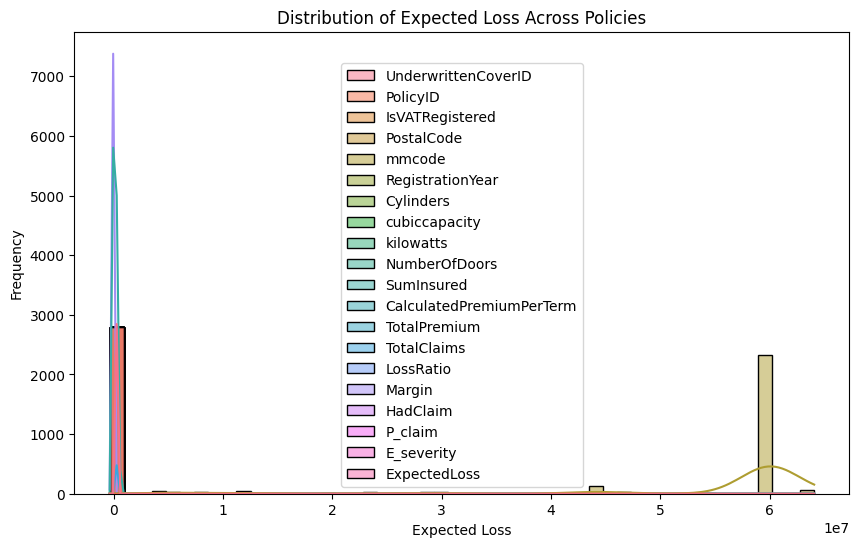

In [ ]:
# Visualize the distribution of Expected Loss
plt.figure(figsize=(10,6))
sns.histplot(df_results[df_results['ExpectedLoss']>0], bins=50, kde=True, color='skyblue')   # since most policies have ExpectedLoss = 0, we filter out those rows for better visualization
plt.title('Distribution of Expected Loss Across Policies')
plt.xlabel('Expected Loss')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Define Expense Loading and Profit Margin (adjust values as necessary)
expense_loading = 500  # Example: 500 ETB fixed expense per policy
profit_margin = 200    # Example: 200 ETB desired profit per policy

# Calculate optimized premium using the new formula
df_results['OptimizedPremium'] = (
    df_results['ExpectedLoss'].where(df_results['ExpectedLoss'] > 0) 
    + expense_loading 
    + profit_margin
)

# Replace NaNs with the corresponding values from df["TotalPremium"]
df_results['OptimizedPremium'] = df_results['OptimizedPremium'].fillna(df['TotalPremium'])


df_results[['PolicyID', 'ExpectedLoss', 'OptimizedPremium']].head(10)
df_results[df_results['ExpectedLoss'] > 0][['PolicyID', 'ExpectedLoss', 'OptimizedPremium']].sort_values(by='ExpectedLoss', ascending=False).head(10)


,PolicyID,ExpectedLoss,OptimizedPremium
502748,7258,86998.070142,87698.070142
495741,7258,72132.024110,72832.024110
533817,7258,70208.668645,70908.668645
559234,2441,66891.460169,67591.460169
495692,7258,59050.701463,59750.701463
520460,7258,58689.090280,59389.090280
343892,7588,35971.791875,36671.791875
84489,6756,28950.934304,29650.934304
392331,442,23929.257418,24629.257418
53865,10043,23222.227988,23922.227988


In [46]:
# Ensure TotalPremium exists
if 'TotalPremium' not in df_results.columns:
    df_results = df_results.merge(df[['PolicyID', 'TotalPremium']], on='PolicyID', how='left')

# Calculate change
df_results['PremiumChange'] = df_results['OptimizedPremium'] - df_results['TotalPremium']
df_results[['PolicyID', 'TotalPremium', 'OptimizedPremium', 'PremiumChange']].head(10)
df_results[df_results['ExpectedLoss'] > 0][['PolicyID',"ExpectedLoss", 'TotalPremium', 'OptimizedPremium', 'PremiumChange']].sort_values(by='ExpectedLoss', ascending=False).head(10)


,PolicyID,ExpectedLoss,TotalPremium,OptimizedPremium,PremiumChange
502748,7258,86998.070142,60143.249924,87698.070142,27554.820218
495741,7258,72132.024110,65282.603421,72832.024110,7549.420689
533817,7258,70208.668645,64291.060263,70908.668645,6617.608382
559234,2441,66891.460169,0.000000,67591.460169,67591.460169
495692,7258,59050.701463,65282.603421,59750.701463,-5531.901958
520460,7258,58689.090280,65282.603421,59389.090280,-5893.513141
343892,7588,35971.791875,0.000000,36671.791875,36671.791875
84489,6756,28950.934304,0.000000,29650.934304,29650.934304
392331,442,23929.257418,0.000000,24629.257418,24629.257418
53865,10043,23222.227988,0.000000,23922.227988,23922.227988


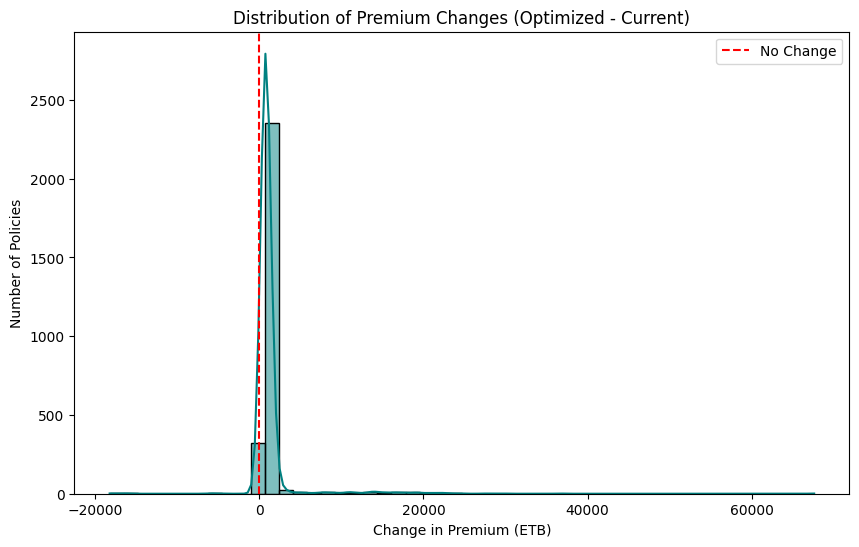

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_results[df_results['ExpectedLoss'] > 0]['PremiumChange'], bins=50, kde=True, color='teal')
plt.title('Distribution of Premium Changes (Optimized - Current)')
plt.xlabel('Change in Premium ')
plt.ylabel('Number of Policies')
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.legend()
plt.show()


In [48]:
df_results.to_csv("../../Data/premium_optimized_data.csv", index=False)

## 💰 Premium Optimization Strategy

### Formula Used:

\[
\text{Optimized Premium} = (P(\text{Claim}) \times E(\text{Severity} | \text{Claim})) + \text{Expense Loading} + \text{Profit Margin}
\]

Where:
- **P(Claim):** Predicted probability of a claim
- **E(Severity | Claim):** Expected severity of claim, given a claim occurs
- **Expense Loading:** 500 ETB (covers administrative and operational costs)
- **Profit Margin:** 200 ETB (target profit per policy)

### Parameters Used:
| Parameter        | Value      |
|------------------|------------|
| **Expense Loading** | 500     |
| **Profit Margin**   | 200     |  

### Key Observations:
- Riskier policies saw **higher premium increases**.
- **Low-risk customers** saw minimal increases, benefiting retention efforts.
- Distribution of premium changes suggests **targeted rebalancing** of pricing is beneficial.

### Recommendations:
- Further refinement by **segment (e.g., VehicleType, Province)** for tailored pricing.
- Incorporate **variable expense loading** based on policy complexity or channel.
- Conduct **actuarial validation** before operational rollout.
